<a href="https://colab.research.google.com/github/gunjanak/Pytorch_Course/blob/main/7_CNN_on_Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,random_split
from torchvision import transforms
from torchvision.io import read_image
from pathlib import Path
from glob import glob
from PIL import Image
import numpy as np

In [2]:
class FruitsDataset(Dataset):
  def __init__(self,root_folder,transform=None):
    self.root_folder = Path(root_folder)
    self.classes = sorted([folder.name for folder in self.root_folder.glob('*')])
    self.class_to_idx = {cls:idx for idx,cls in enumerate(self.classes)}
    self.images = self._load_images()
    self.transform = transform

  def _load_images(self):
    images = []
    for cls in self.classes:
      class_folder = self.root_folder/cls
      class_images = glob(str(class_folder / '*.jpg'))
      images.extend([(image,cls) for image in class_images])
    return images



  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    img_path,label = self.images[idx]
    #Read the image as a PyTorch Tensor
    image = read_image(img_path)
    #convert the PyTorch Tensor to a PIL Image
    image = transforms.ToPILImage()(image)
    if self.transform:
      image = self.transform(image)
    target = self.class_to_idx[label]
    return image,target

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

In [4]:
#specify the path to your root folder
root_folder = '/content/drive/MyDrive/Colab Notebooks/Python_Course/PyTorch_Course/Fruits'

In [5]:
#Create the dataset
dataset = FruitsDataset(root_folder=root_folder,transform=data_transform)


In [6]:
#Define the ratio for train and test split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

In [7]:
#Split the dataset into train and test
train_dataset,test_dataset = random_split(dataset,[train_size,test_size])

In [8]:
type(train_dataset[0])

tuple

In [9]:
#Accessing a sample from the train set
sample_image_train,sample_label_train = train_dataset[0]

In [10]:
#Define the ratio for train and test split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

In [11]:
#Split the dataset into train and test
train_dataset, test_dataset = random_split(dataset,[train_size,test_size])

In [12]:
import matplotlib.pyplot as plt

1


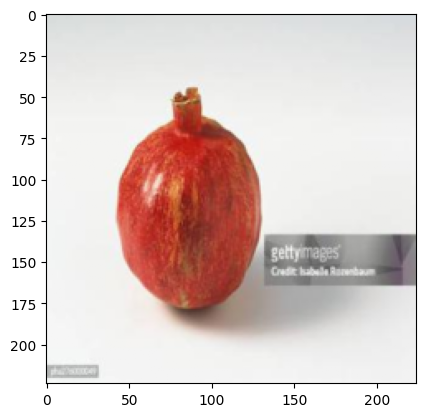

In [13]:
#Accessing a sample from the train set
sample_image_train,sample_label_train = train_dataset[925]
plt.imshow(sample_image_train.permute(1,2,0).cpu())
print(sample_label_train)


In [14]:
#Accessing a sample from the test set
sample_image_test,sample_label_test = test_dataset[0]

3


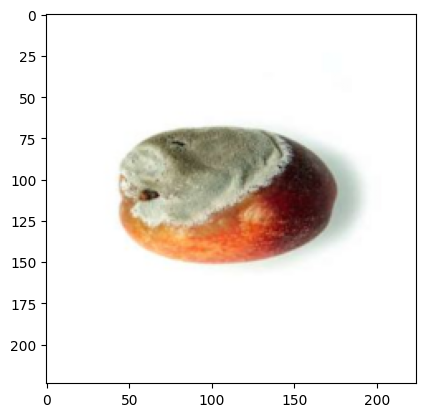

In [15]:
plt.imshow(sample_image_test.permute(1,2,0).cpu())
print(sample_label_test)


In [16]:
len(train_dataset)

1152

In [17]:
len(test_dataset)

288

In [18]:
class SimpleCNN(nn.Module):
  def __init__(self,num_classes):
    super(SimpleCNN,self).__init__()

    self.conv1 = nn.Conv2d(3,64,kernel_size=3,padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv2 = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.conv3 = nn.Conv2d(64,64,kernel_size=3,padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64*28*28,512)
    self.relu4 = nn.ReLU()
    self.fc2 = nn.Linear(512,num_classes)

  def forward(self,x):
    x = self.pool1(self.relu1(self.conv1(x)))

    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.pool3(self.relu3(self.conv3(x)))
    # print(x.size())

    x = self.flatten(x)
    x = self.relu4(self.fc1(x))
    x = self.fc2(x)

    return x






In [19]:
num_classes = len(dataset.classes)
num_classes

6

In [20]:
model = SimpleCNN(num_classes=num_classes)

In [21]:
#move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#print the model architecture
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)


#Training

In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score

In [23]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [24]:
#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [25]:
#Set up Tensorboard for Visualization (optional)
writer = SummaryWriter()

In [26]:
writer

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [28]:
#Training loop
num_epochs = 20
epoch_train_accuracy = []
epoch_train_loss = []
epoch_test_accuracy = []
epoch_test_loss = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0
  all_predicted_train = []
  all_labels_train = []

  for images,labels in train_loader:
    images,labels = images.to(device),labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs,labels.long())
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _,predicted = torch.max(outputs.data,1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()
    # Collect predictions and true labels for confusion matrix
    all_predicted_train.extend(predicted.cpu().numpy())
    all_labels_train.extend(labels.cpu().numpy())

  average_loss = running_loss/len(train_loader)
  accuracy_train = correct_train/total_train
  epoch_train_accuracy.append(accuracy_train)
  epoch_train_loss.append(average_loss)
  writer.add_scalar('Loss/Train',average_loss,epoch)
  writer.add_scalar('Accuracy/Train',accuracy_train,epoch)

  print(f'Epoch [{epoch + 1}/{num_epochs}],'
  f'Trainin Loss: {average_loss: .4f},'
  f'Training Accuracy: {100*accuracy_train:.2f}%')

  #Validation loop
  model.eval()
  correct_val = 0
  total_val = 0
  val_loss = 0.0
  all_predicted_val = []
  all_labels_val = []

  with torch.no_grad():
    for images,labels in test_loader:
      images,labels = images.to(device),labels.to(device)

      outputs = model(images)
      loss = criterion(outputs,labels.long())
      val_loss += loss.item()

      _,predicted = torch.max(outputs.data,1)
      total_val += labels.size(0)
      correct_val += (predicted == labels).sum().item()

      # Collect predictions and true labels for confusion matrix
      all_predicted_val.extend(predicted.cpu().numpy())
      all_labels_val.extend(labels.cpu().numpy())

  average_val_loss = val_loss/len(test_loader)
  accuracy_val = correct_val/total_val
  epoch_test_accuracy.append(accuracy_val)
  epoch_test_loss.append(average_val_loss)

  writer.add_scalar('Loss/Validation',average_val_loss,epoch)
  writer.add_scalar('Accuracy/Validation',accuracy_val,epoch)

  print(f'Validation Loss: {average_val_loss: .4f},'
  f'Validation Accuracy : {100*accuracy_val: .2f}%')



Epoch [1/20],Trainin Loss:  1.6140,Training Accuracy: 30.73%
Validation Loss:  1.4148,Validation Accuracy :  40.97%
Epoch [2/20],Trainin Loss:  1.2466,Training Accuracy: 51.04%
Validation Loss:  1.3046,Validation Accuracy :  46.18%
Epoch [3/20],Trainin Loss:  1.0992,Training Accuracy: 57.99%
Validation Loss:  1.1565,Validation Accuracy :  56.60%
Epoch [4/20],Trainin Loss:  0.9275,Training Accuracy: 65.19%
Validation Loss:  1.0826,Validation Accuracy :  59.72%
Epoch [5/20],Trainin Loss:  0.8075,Training Accuracy: 70.49%
Validation Loss:  0.8869,Validation Accuracy :  65.62%
Epoch [6/20],Trainin Loss:  0.5769,Training Accuracy: 79.17%
Validation Loss:  0.8023,Validation Accuracy :  69.44%
Epoch [7/20],Trainin Loss:  0.4474,Training Accuracy: 84.55%
Validation Loss:  0.7734,Validation Accuracy :  75.69%
Epoch [8/20],Trainin Loss:  0.3645,Training Accuracy: 87.50%
Validation Loss:  0.6994,Validation Accuracy :  76.39%
Epoch [9/20],Trainin Loss:  0.3551,Training Accuracy: 86.46%
Validation 

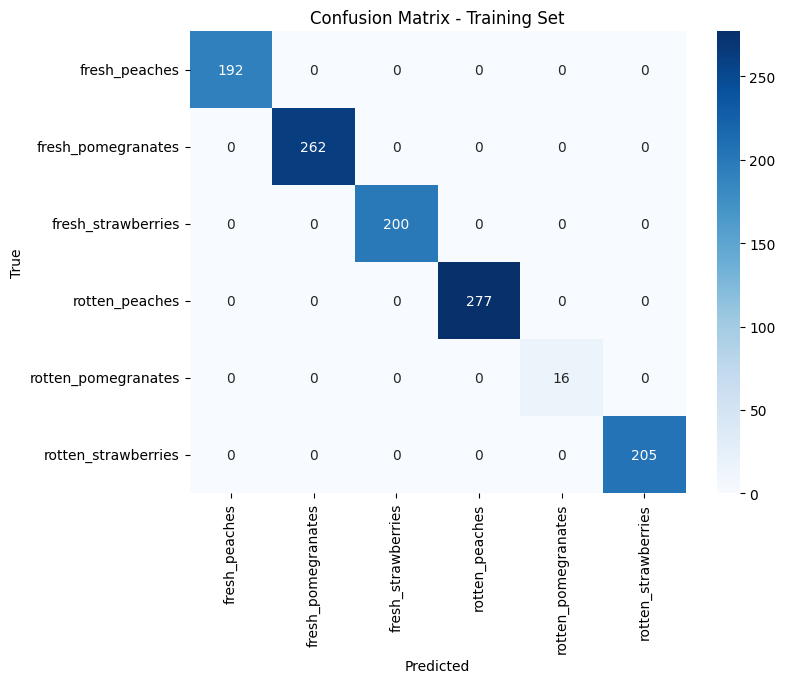

In [29]:
# Confusion matrix for training set
cm_train = confusion_matrix(all_labels_train, all_predicted_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Text(70.5815972222222, 0.5, 'True')

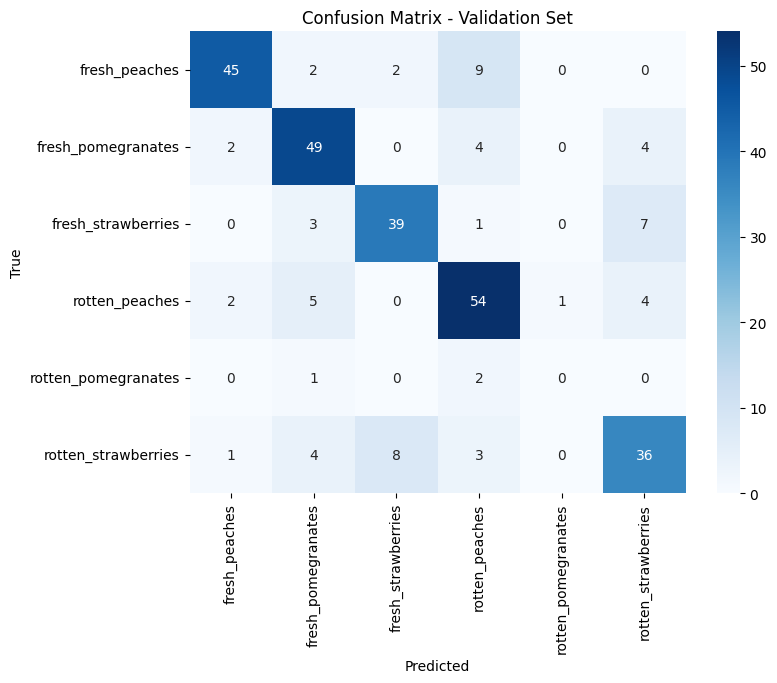

In [30]:
# Confusion matrix for validation set
cm_val = confusion_matrix(all_labels_val, all_predicted_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('True')

In [31]:
#Save the model
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Python_Course/PyTorch_Course/Fruit_classification_cnn_model.pth')

#Reload the model

In [32]:
model_loaded = SimpleCNN(num_classes=6)
model_loaded.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Python_Course/PyTorch_Course/Fruit_classification_cnn_model.pth'))
model_loaded.eval()

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=6, bias=True)
)

In [33]:
#Image preprocessing
def preprocess_image(image_path):
  image = Image.open(image_path)
  transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
  ])
  image = transform(image).unsqueeze(0)
  return image

In [38]:
#Function to classify an image
def classify_image(image_path):
  image = preprocess_image(image_path)
  # Convert the PyTorch tensor back to a PIL Image for visualization
  image_pil = transforms.ToPILImage()(image.squeeze(0))

  with torch.no_grad():
    image = image.to(device).float()
    output = model(image)

  _,predicted_class = torch.max(output,1)

  fruits = {
      2: "Fresh strawberry",
      0: "Fresh Peach",
      1:"Fresh Pomegranate",
      5:"Rotten Strawberry",
      3:"Rotten Peach",
      4:"Rotten Pomegranate"
  }
  print(fruits[predicted_class.item()])

  # Display the image
  plt.imshow(image_pil)
  plt.axis('off')
  plt.title(f'Predicted Class: {fruits[predicted_class.item()]}')
  plt.show()
  return predicted_class.item()

In [35]:
from glob import glob
from google.colab import files

Saving rotten_pomegranate_64.jpg to rotten_pomegranate_64.jpg
Rotten Peach


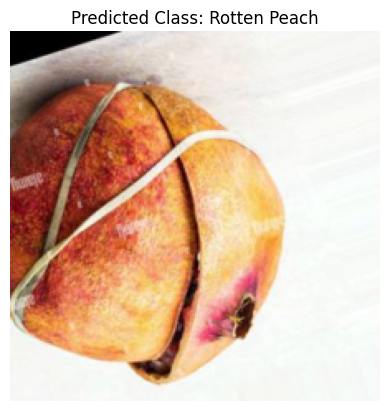

3

In [39]:
uploaded = files.upload()
file_name = uploaded.keys()
file_name = list(file_name)[0]
classify_image(file_name)

In [ ]:
epoch_test_accuracy

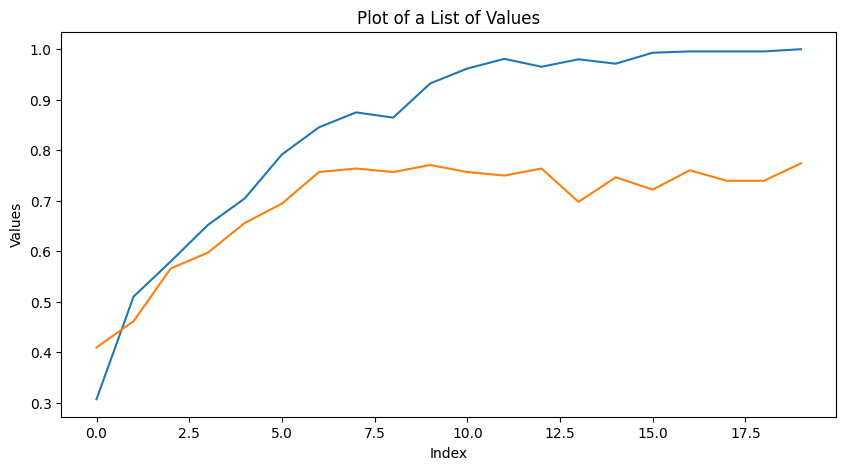

In [46]:
# Plotting the values
plt.plot(epoch_train_accuracy)
plt.plot(epoch_test_accuracy)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of a List of Values')

# Display the plot
plt.show()

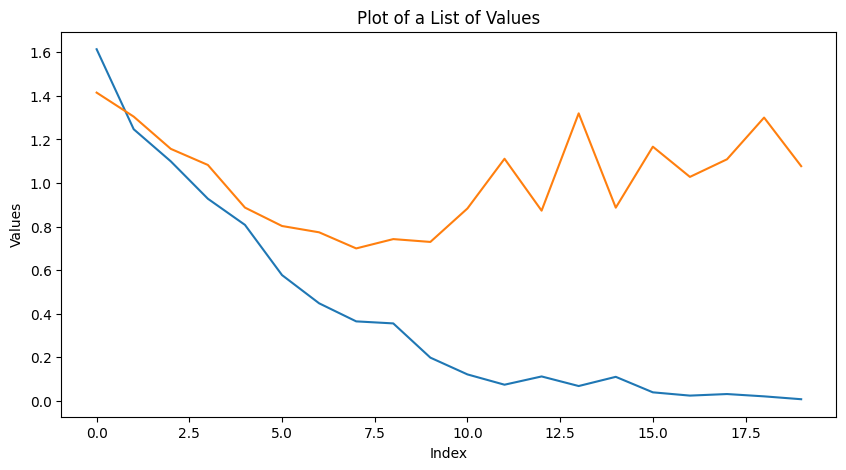

In [47]:
# Plotting the values
plt.plot(epoch_train_loss)
plt.plot(epoch_test_loss)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of a List of Values')

# Display the plot
plt.show()